# SC4000

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import LabelEncoder

# Load base data
historical_df = pd.read_csv('Downloads/elo-merchant-category-recommendation/historical_transactions.csv')
new_merchants_df = pd.read_csv('Downloads/elo-merchant-category-recommendation/new_merchant_transactions.csv')
merchants_df = pd.read_csv('Downloads/elo-merchant-category-recommendation/merchants.csv')

In [2]:
# Process merchant data
def process_merchants(df):
    # Handle categorical variables
    cat_cols = ['category_1', 'category_2', 'category_4', 'most_recent_sales_range', 
                'most_recent_purchases_range']
    for col in cat_cols:
        if col in df.columns:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
    
    # Handle numerical variables - fill missing values
    num_cols = ['numerical_1', 'numerical_2', 'avg_sales_lag3', 'avg_purchases_lag3',
               'active_months_lag3', 'avg_sales_lag6', 'avg_purchases_lag6',
               'active_months_lag6', 'avg_sales_lag12', 'avg_purchases_lag12',
               'active_months_lag12']
    for col in num_cols:
        if col in df.columns:
            df[col].fillna(df[col].median(), inplace=True)
    
    return df

# Process merchant data (using new variable names)
merchants_processed = process_merchants(merchants_df)

In [3]:
def process_transactions(df):
    # Convert date
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['purchase_year'] = df['purchase_date'].dt.year
    df['purchase_month'] = df['purchase_date'].dt.month
    df['purchase_day'] = df['purchase_date'].dt.day
    df['purchase_weekday'] = df['purchase_date'].dt.weekday
    df['purchase_hour'] = df['purchase_date'].dt.hour
    
    # Handle categorical variables
    cat_cols = ['authorized_flag', 'category_1', 'category_2', 'category_3']
    for col in cat_cols:
        if col in df.columns:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
    
    # Handle numerical variables
    df['installments'].replace(-1, 0, inplace=True)
    df['installments'].replace(999, 12, inplace=True)  # Assume 999 represents more than 12 installments
    
    return df

# Process transaction data (using new variable names)
historical_processed = process_transactions(historical_df)
new_merchants_processed = process_transactions(new_merchants_df)

In [4]:
def reduce_memory_usage(df):
    # Convert float64 columns to float32
    float_cols = df.select_dtypes(include=['float64']).columns
    for col in float_cols:
        df[col] = df[col].astype('float32')
    return df

# Apply memory reduction to historical and new_merchants DataFrames
historical_processed_reduced = process_transactions(historical_processed)
new_merchants_processed_reduced = process_transactions(new_merchants_processed)

In [10]:
def create_card_features(df, prefix):
    # Aggregate statistical features
    agg_func = {
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std', 'count'],
        'installments': ['sum', 'mean', 'max', 'min', 'std'],
        'month_lag': ['mean', 'max', 'min', 'std'],
        'merchant_id': ['nunique'],
        'merchant_category_id': ['nunique'],
        'subsector_id': ['nunique'],
        'city_id': ['nunique'],
        'state_id': ['nunique'],
        'category_1': ['mean'],
        'category_2': ['mean'],
        'category_3': ['mean']
    }
    
    agg_df = df.groupby('card_id').agg(agg_func)
    agg_df.columns = [prefix + '_'.join(col).strip() for col in agg_df.columns.values]
    agg_df.reset_index(inplace=True)
    
    # Time-related features
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    last_date = df['purchase_date'].max()
    
    time_agg = df.groupby('card_id')['purchase_date'].agg([
        ('last_purchase', lambda x: (last_date - x.max()).days),
        ('first_purchase', lambda x: (last_date - x.min()).days),
        ('purchase_freq', lambda x: (x.max() - x.min()).days / len(x) if len(x) > 1 else 0)
    ])
    time_agg.columns = [prefix + col for col in time_agg.columns]
    time_agg.reset_index(inplace=True)
    
    # Merge features
    agg_df = agg_df.merge(time_agg, on='card_id', how='left')
    
    return agg_df

In [14]:
# Create features (using new variable names)
hist_features_agg = create_card_features(historical_processed, 'hist_')
new_features_agg = create_card_features(new_merchants_processed, 'new_')

# Merge merchant features (using new variable names)
historical_with_merchants = historical_processed.merge(merchants_processed, on='merchant_id', how='left')
new_merchants_with_merchants = new_merchants_processed.merge(merchants_processed, on='merchant_id', how='left')

In [15]:
# Create merchant-related features
def create_merchant_features(df, prefix):
    merchant_agg = {
        'merchant_group_id': ['nunique'],
        'numerical_1': ['mean', 'std'],
        'numerical_2': ['mean', 'std'],
        'avg_sales_lag3': ['mean'],
        'avg_purchases_lag3': ['mean'],
        'active_months_lag3': ['sum']
    }
    
    merchant_df = df.groupby('card_id').agg(merchant_agg)
    merchant_df.columns = [prefix + '_'.join(col).strip() for col in merchant_df.columns.values]
    merchant_df.reset_index(inplace=True)
    
    return merchant_df

In [16]:
# Create merchant-related features (using new variable names)
hist_merchant_features_agg = create_merchant_features(historical_with_merchants, 'hist_m_')
new_merchant_features_agg = create_merchant_features(new_merchants_with_merchants, 'new_m_')

In [17]:
train_df = pd.read_csv('Downloads/elo-merchant-category-recommendation/train.csv')
test_df = pd.read_csv('Downloads/elo-merchant-category-recommendation/test.csv')

In [18]:
# Process base data
def process_base(df):
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['month'] = df['first_active_month'].dt.month
    df['year'] = df['first_active_month'].dt.year
    df['elapsed_time'] = (pd.to_datetime('2025-04-01') - df['first_active_month']).dt.days
    
    # Process categorical features
    for col in ['feature_1', 'feature_2', 'feature_3']:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
    
    return df

# Process base data (using new variable names)
train_processed = process_base(train_df)
test_processed = process_base(test_df)

In [22]:
# Merge all features
def merge_all_features(base_df):
    # Merge historical transaction features
    merged_df = base_df.merge(hist_features_agg, on='card_id', how='left')
    
    # Merge new merchant transaction features
    merged_df = merged_df.merge(new_features_agg, on='card_id', how='left')
    
    # Merge merchant features from historical transactions
    merged_df = merged_df.merge(hist_merchant_features_agg, on='card_id', how='left')
    
    # Merge merchant features from new merchants
    merged_df = merged_df.merge(new_merchant_features_agg, on='card_id', how='left')
    return merged_df

# Merge all features (using new variable names)
train_full = merge_all_features(train_processed)
test_full = merge_all_features(test_processed)

In [41]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# 1. Data preparation
features = [col for col in train_full.columns if col not in ['card_id', 'target', 'first_active_month']]
X = train_full[features]
y = train_full['target']

# 2. Data preprocessing
# Handle infinity and missing values
X = X.replace([np.inf, -np.inf], np.nan)
imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(X), columns=features)

# Numerical standardization (optional, LightGBM typically doesn't need it, but may improve performance in some scenarios)
# scaler = StandardScaler()
# X = pd.DataFrame(scaler.fit_transform(X), columns=features)

In [42]:
# 3. Data splitting  
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)  

# 4. Convert to LightGBM Dataset format (for efficiency)  
train_data = lgb.Dataset(X_train, label=y_train)  
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

In [46]:
# 5. Set LightGBM parameters
params = {
    'objective': 'regression',     # Regression task
    'metric': 'rmse',             # Evaluation metric: RMSE
    'boosting_type': 'gbdt',      # Gradient Boosting Decision Tree
    'num_leaves': 31,             # Maximum leaves per tree
    'learning_rate': 0.05,        # Learning rate
    'feature_fraction': 0.9,      # Randomly select 90% features each iteration
    'bagging_fraction': 0.8,      # Randomly sample 80% data
    'bagging_freq': 5,            # Perform bagging every 5 iterations
    'verbose': -1,                # No logging
    'seed': 42                    # Random seed
}

optimized_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 63,                # Increased number of leaves (original: 31)
    'learning_rate': 0.02,           # Reduced learning rate (original: 0.05)
    'feature_fraction': 0.8,         # Reduced feature sampling ratio (original: 0.9)
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_child_samples': 20,         # New: Prevent overfitting
    'reg_alpha': 0.1,                # New: L1 regularization
    'reg_lambda': 0.1,               # New: L2 regularization
    'max_depth': -1,                 # Remove depth limit
    'min_data_in_leaf': 40,          # New: Minimum data in leaf
    'max_bin': 255,                  # Increased number of histogram bins
    'verbose': -1,
    'seed': 42
}

optimized_params_v2 = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    
    'num_leaves': 127,              # Increased model complexity (default:31, previous:63) trying 127
    'learning_rate': 0.01,          # Further reduced learning rate, compensate with more iterations

    'feature_fraction': 0.85,       # Slightly increased feature sampling ratio
    'bagging_fraction': 0.75,       # Slightly more conservative to avoid overfitting
    'bagging_freq': 5,

    'min_child_samples': 10,        # Reduced minimum samples to learn finer features
    'min_data_in_leaf': 20,         # Reduced data required in leaves
    
    'reg_alpha': 0.05,              # Kept regularization but slightly relaxed
    'reg_lambda': 0.05,

    'max_depth': -1,                # No depth limit, with other regularizations
    'max_bin': 255,

    'n_estimators': 10000,          # Larger number of iterations
    'early_stopping_round': 100,    # Early stopping with validation set
    'verbose': -1,
    'seed': 42
}

# 6. Train model
model = lgb.train(
    optimized_params,
    train_data,
    num_boost_round=2000,         # Number of iterations
    valid_sets=[val_data], 
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),  # Early stopping
        lgb.log_evaluation(period=50)            # Log every 50 rounds
    ]
)

# 7. Prediction and evaluation
val_preds = model.predict(X_val, num_iteration=model.best_iteration)
rmse = np.sqrt(mean_squared_error(y_val, val_preds))
print(f"\nValidation RMSE: {rmse:.4f}")

Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 3.74857
[100]	valid_0's rmse: 3.72161
[150]	valid_0's rmse: 3.71354
[200]	valid_0's rmse: 3.70928
[250]	valid_0's rmse: 3.70767
[300]	valid_0's rmse: 3.70574
[350]	valid_0's rmse: 3.70522
[400]	valid_0's rmse: 3.70491
[450]	valid_0's rmse: 3.70418
[500]	valid_0's rmse: 3.7043
[550]	valid_0's rmse: 3.70536
Early stopping, best iteration is:
[476]	valid_0's rmse: 3.70367

Validation RMSE: 3.7037



Top 20 Important Features:
                           feature     importance
56              new_first_purchase  989040.655231
29              hist_last_purchase  786221.234375
26            hist_category_1_mean  726338.003220
55               new_last_purchase  677993.569996
12           hist_installments_sum  654043.632992
34         new_purchase_amount_max  567810.645084
20              hist_month_lag_std  529590.657860
17             hist_month_lag_mean  416905.667908
6         hist_purchase_amount_sum  406259.199402
43              new_month_lag_mean  382244.271461
9         hist_purchase_amount_min  363271.618050
19              hist_month_lag_min  361672.168823
31              hist_purchase_freq  345199.694633
30             hist_first_purchase  336095.802391
11      hist_purchase_amount_count  326310.948372
57               new_purchase_freq  301409.101486
7        hist_purchase_amount_mean  293287.789482
8         hist_purchase_amount_max  287904.978027
64  hist_m_avg_purchas

<Figure size 1000x600 with 0 Axes>

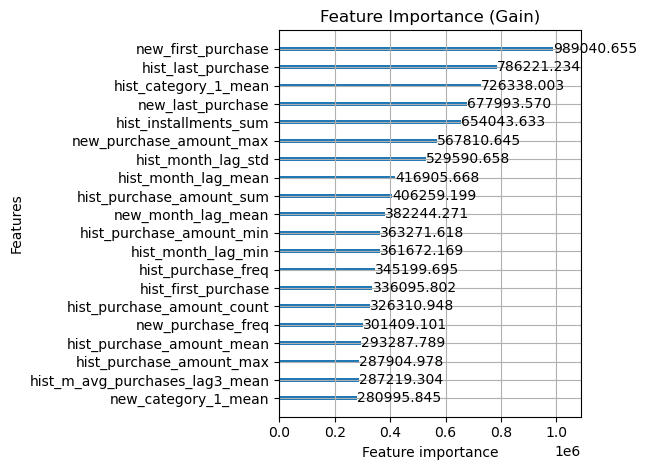

In [47]:
# 8. Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importance(importance_type='gain')  # Sorted by information gain
}).sort_values('importance', ascending=False)

print("\nTop 20 Important Features:")
print(feature_importance.head(20))

# 9. Visualize feature importance
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
lgb.plot_importance(model, max_num_features=20, importance_type='gain')
plt.title("Feature Importance (Gain)")
plt.tight_layout()
plt.show()

In [48]:
# 10. Load and preprocess test data
test_features = test_full[features]  # Use same features as training set

# Ensure same preprocessing as training set
test_features = test_features.replace([np.inf, -np.inf], np.nan)
test_features = pd.DataFrame(imputer.transform(test_features), columns=features)

test_preds = model.predict(test_features, num_iteration=model.best_iteration)

# 11. Generate submission file
submission = pd.DataFrame({
    'card_id': test_full['card_id'],
    'target': test_preds
})
submission.to_csv('submission_lightgbm_v4.csv', index=False)

print("\nSubmission file saved as 'submission_lightgbm.csv'")
print(submission.head())


Submission file saved as 'submission_lightgbm.csv'
           card_id    target
0  C_ID_0ab67a22ab -1.657980
1  C_ID_130fd0cbdd -0.082582
2  C_ID_b709037bc5 -0.807366
3  C_ID_d27d835a9f -0.222076
4  C_ID_2b5e3df5c2 -0.818539
